In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
from polygraphs.analysis import Processor

In [15]:
class BeliefProcessor(Processor):
    def __init__(self, path):
        super().__init__(path)
        # Add the columns when processor is initialized
        self.add(self.mean(0.5, 0.75, 0.9, 0.99), self.quantile(0.5, 0.75, 0.9, 0.99, quantiles=(0.25,)))
        

    def mean(self, *thresholds):
        """Use the beliefs dataframe to find when mean beliefs first met a given threshold and count threshold crossings."""
        def get_mean_with_recrossings(iterations, threshold=0.5):
            # Average belief of all nodes at each iteration
            mean_iteration = iterations.groupby("iteration").mean()

            # Track crossing events
            above_threshold = mean_iteration["beliefs"] > threshold
            crossings = ((above_threshold & ~above_threshold.shift(fill_value=False))|
                         (~above_threshold & above_threshold.shift(fill_value=False))).sum()
            
            # Detect first crossing
            first_crossing = mean_iteration[above_threshold].index[0] if above_threshold.any() else None
            
            return first_crossing, crossings
        
        # Loop through list of arguments
        for threshold in thresholds:
            threshold = float(threshold)
            if 0 <= threshold <= 1:
                # Call the function for each simulation belief
                first_crossing_list = []
                crossing_count_list = []
                for belief in self.beliefs:
                    first_crossing, crossing_count = get_mean_with_recrossings(belief, threshold)
                    first_crossing_list.append(first_crossing)
                    crossing_count_list.append(crossing_count)

                # Add columns to the dataframe
                column = "mean_" + str(threshold).replace(".", "_")
                crossing_column = column + "_crossings"
                self.dataframe[column] = first_crossing_list
                self.dataframe[crossing_column] = crossing_count_list

    def quantile(self, *thresholds, quantiles=(0.25,)):
        def get_quantile(iterations, threshold, quantile_level):
            # Find the specified quantile of all nodes at each iteration
            quantile_iteration = iterations.groupby("iteration").quantile(quantile_level)
            
            above_threshold = quantile_iteration['beliefs'] > threshold
            count_crossings = ((above_threshold & ~above_threshold.shift(fill_value=False))|
                               (~above_threshold & above_threshold.shift(fill_value=False))).sum()
            
            # Filter out the iterations that do not meet threshold
            iterations_above_threshold = quantile_iteration[quantile_iteration['beliefs'] > threshold]
            
            # Check that we found a threshold
            if len(iterations_above_threshold) > 0:
                # Return the first remaining iteration (the index) and count of crossings
                return iterations_above_threshold.index[0], count_crossings
            else:
                return None, count_crossings

        # Loop through thresholds and quantiles
        for threshold in thresholds:
            threshold = float(threshold)
            if 0 <= threshold <= 1:
                for quantile_level in quantiles:
                    if 0 <= quantile_level <= 1:
                        # Call get_quantile function on each simulation beliefs
                        quantile_list = []
                        crossings_list = []
                        for belief in self.beliefs:
                            first_crossing, crossing_count = get_quantile(belief, threshold, quantile_level)
                            quantile_list.append(first_crossing)
                            crossings_list.append(crossing_count)
                        
                        # Add columns to the dataframe
                        column = f"quantile_{str(threshold).replace('.', '_')}_q{int(quantile_level * 100)}"
                        crossing_column = column + "_crossings"
                        self.dataframe[column] = quantile_list
                        self.dataframe[crossing_column] = crossings_list
        
    
    def aggregate_crossings_by_op(self):
        """Aggregate threshold crossings by operator for comparison."""
        aggregated = self.dataframe.copy()

        # Select only numeric columns for aggregation
        numeric_data = aggregated.select_dtypes(include=["number"])

        # Add the 'op' column back for grouping
        numeric_data["op"] = aggregated["op"]

        # Group by operator and sum up crossing counts for each metric
        op_aggregated = numeric_data.groupby("op").sum()

        return op_aggregated




In [16]:
x = BeliefProcessor("../../../CollegeMSG") # ~/polygraphs-cache/results/
x.get()

,bin_file_path,hd5_file_path,config_json_path,trials,network_kind,op,epsilon,steps,duration,action,...,mean_0_99,mean_0_99_crossings,quantile_0_5_q25,quantile_0_5_q25_crossings,quantile_0_75_q25,quantile_0_75_q25_crossings,quantile_0_9_q25,quantile_0_9_q25_crossings,quantile_0_99_q25,quantile_0_99_q25_crossings
0,/Users/prudhvivuda/Documents/CollegeMSG/2024-0...,/Users/prudhvivuda/Documents/CollegeMSG/2024-0...,/Users/prudhvivuda/Documents/CollegeMSG/2024-0...,64.0,snap,BalaGoyalOp,0.001,25000.0,4515.615079,?,...,None,0,900.0,3,2100.0,1,3100.0,1,5100.0,1
1,/Users/prudhvivuda/Documents/CollegeMSG/2024-0...,/Users/prudhvivuda/Documents/CollegeMSG/2024-0...,/Users/prudhvivuda/Documents/CollegeMSG/2024-0...,64.0,snap,BalaGoyalOp,0.001,25000.0,4036.652415,?,...,None,0,1000.0,1,1600.0,3,3600.0,3,5800.0,1
2,/Users/prudhvivuda/Documents/CollegeMSG/2024-0...,/Users/prudhvivuda/Documents/CollegeMSG/2024-0...,/Users/prudhvivuda/Documents/CollegeMSG/2024-0...,64.0,snap,BalaGoyalOp,0.001,25000.0,3101.768095,?,...,None,0,800.0,1,1800.0,1,2600.0,1,5000.0,1
3,/Users/prudhvivuda/Documents/CollegeMSG/2024-0...,/Users/prudhvivuda/Documents/CollegeMSG/2024-0...,/Users/prudhvivuda/Documents/CollegeMSG/2024-0...,64.0,snap,BalaGoyalOp,0.001,25000.0,3121.173365,?,...,None,0,1100.0,1,1700.0,1,2700.0,1,4800.0,1
4,/Users/prudhvivuda/Documents/CollegeMSG/2024-0...,/Users/prudhvivuda/Documents/CollegeMSG/2024-0...,/Users/prudhvivuda/Documents/CollegeMSG/2024-0...,64.0,snap,BalaGoyalOp,0.001,25000.0,3039.922915,?,...,None,0,700.0,1,1600.0,1,2400.0,1,4700.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330,/Users/prudhvivuda/Documents/CollegeMSG/2024-0...,/Users/prudhvivuda/Documents/CollegeMSG/2024-0...,/Users/prudhvivuda/Documents/CollegeMSG/2024-0...,64.0,snap,UnreliableNetworkBasicGullibleBinomialOp,0.001,NaN,NaN,NaN,...,None,0,1700.0,1,2700.0,1,4400.0,1,7400.0,1
331,/Users/prudhvivuda/Documents/CollegeMSG/2024-0...,/Users/prudhvivuda/Documents/CollegeMSG/2024-0...,/Users/prudhvivuda/Documents/CollegeMSG/2024-0...,64.0,snap,UnreliableNetworkBasicGullibleNegativeEpsOp,0.001,NaN,NaN,NaN,...,None,0,2700.0,1,6100.0,3,9800.0,3,15600.0,1
332,/Users/prudhvivuda/Documents/CollegeMSG/2024-0...,/Users/prudhvivuda/Documents/CollegeMSG/2024-0...,/Users/prudhvivuda/Documents/CollegeMSG/2024-0...,64.0,snap,UnreliableNetworkBasicGullibleNegativeEpsOp,0.001,NaN,NaN,NaN,...,None,0,4000.0,1,8200.0,3,NaN,0,NaN,0
333,/Users/prudhvivuda/Documents/CollegeMSG/2024-0...,/Users/prudhvivuda/Documents/CollegeMSG/2024-0...,/Users/prudhvivuda/Documents/CollegeMSG/2024-0...,64.0,snap,UnreliableNetworkIdealOp,0.001,NaN,NaN,NaN,...,None,0,1400.0,1,3000.0,3,4600.0,1,7000.0,1


In [17]:
x.get().shape

(335, 30)

In [18]:
x.get().count()

bin_file_path                  335
hd5_file_path                  335
config_json_path               335
trials                         335
network_kind                   335
op                             335
epsilon                        335
steps                          228
duration                       228
action                         228
undefined                      228
converged                      228
polarized                      228
uid                            335
mean_0_5                       335
mean_0_5_crossings             335
mean_0_75                      327
mean_0_75_crossings            335
mean_0_9                       212
mean_0_9_crossings             335
mean_0_99                        0
mean_0_99_crossings            335
quantile_0_5_q25               329
quantile_0_5_q25_crossings     335
quantile_0_75_q25              301
quantile_0_75_q25_crossings    335
quantile_0_9_q25               275
quantile_0_9_q25_crossings     335
quantile_0_99_q25   

In [19]:
op_aggregated = x.aggregate_crossings_by_op()

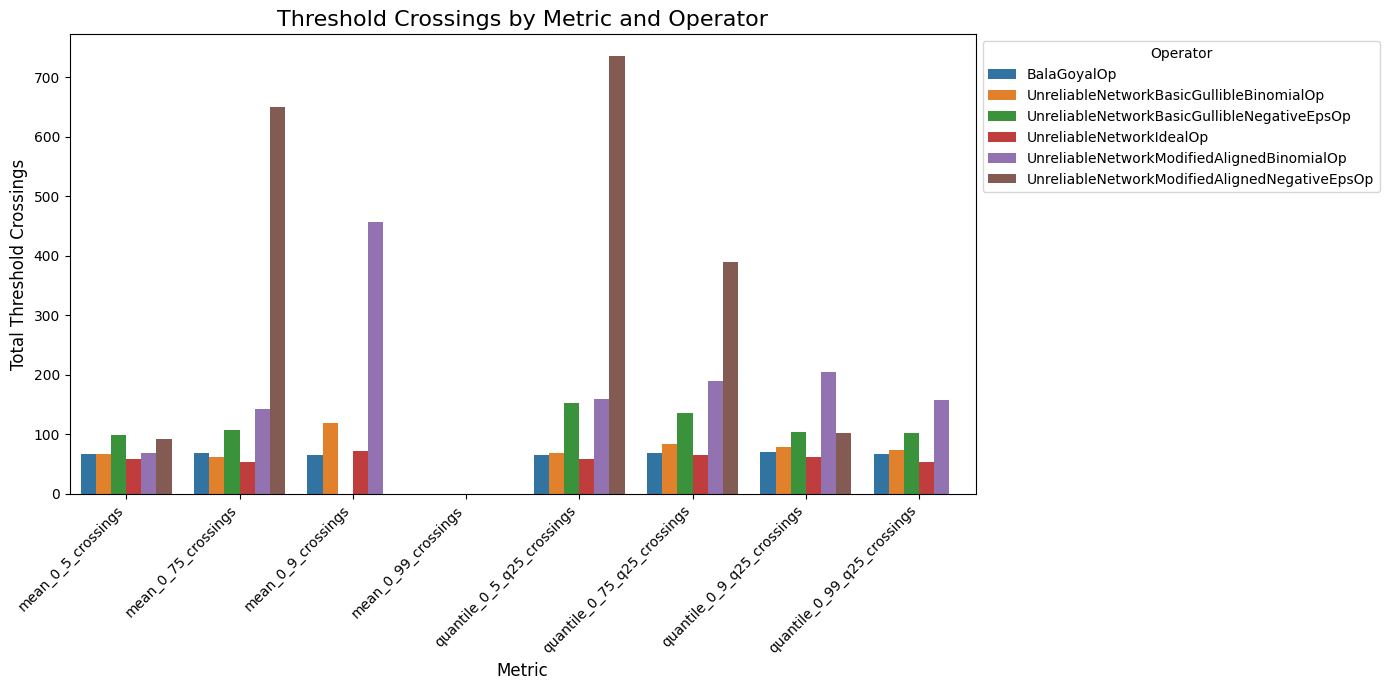

In [31]:
# Transform the data for easier visualization
crossing_metrics = op_aggregated.filter(like="crossings").reset_index()

# Melt the DataFrame for seaborn compatibility
melted_metrics = crossing_metrics.melt(id_vars=["op"], var_name="Metric", value_name="Threshold_Crossings")

# Plot threshold crossings by metrics for each operator
plt.figure(figsize=(14, 7))
sns.barplot(data=melted_metrics, x="Metric", y="Threshold_Crossings", hue="op", palette="tab10")
plt.xticks(rotation=45, ha="right")
plt.title("Threshold Crossings by Metric and Operator", fontsize=16)
plt.xlabel("Metric", fontsize=12)
plt.ylabel("Total Threshold Crossings", fontsize=12)
plt.legend(title="Operator", bbox_to_anchor=(1, 1), loc="upper left")
plt.tight_layout()

# save the plot
plt.savefig("images/threshold crossings by metric and operator.png", format="png", dpi=300, bbox_inches="tight")
plt.savefig("images/threshold crossings by metric and operator.svg", format="svg", bbox_inches="tight")

plt.show()

/var/folders/1c/f0l1c8xj21b5_d53qldvsm200000gn/T/ipykernel_3925/3158394295.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_metric, x="op", y=metric_name, palette="tab10")


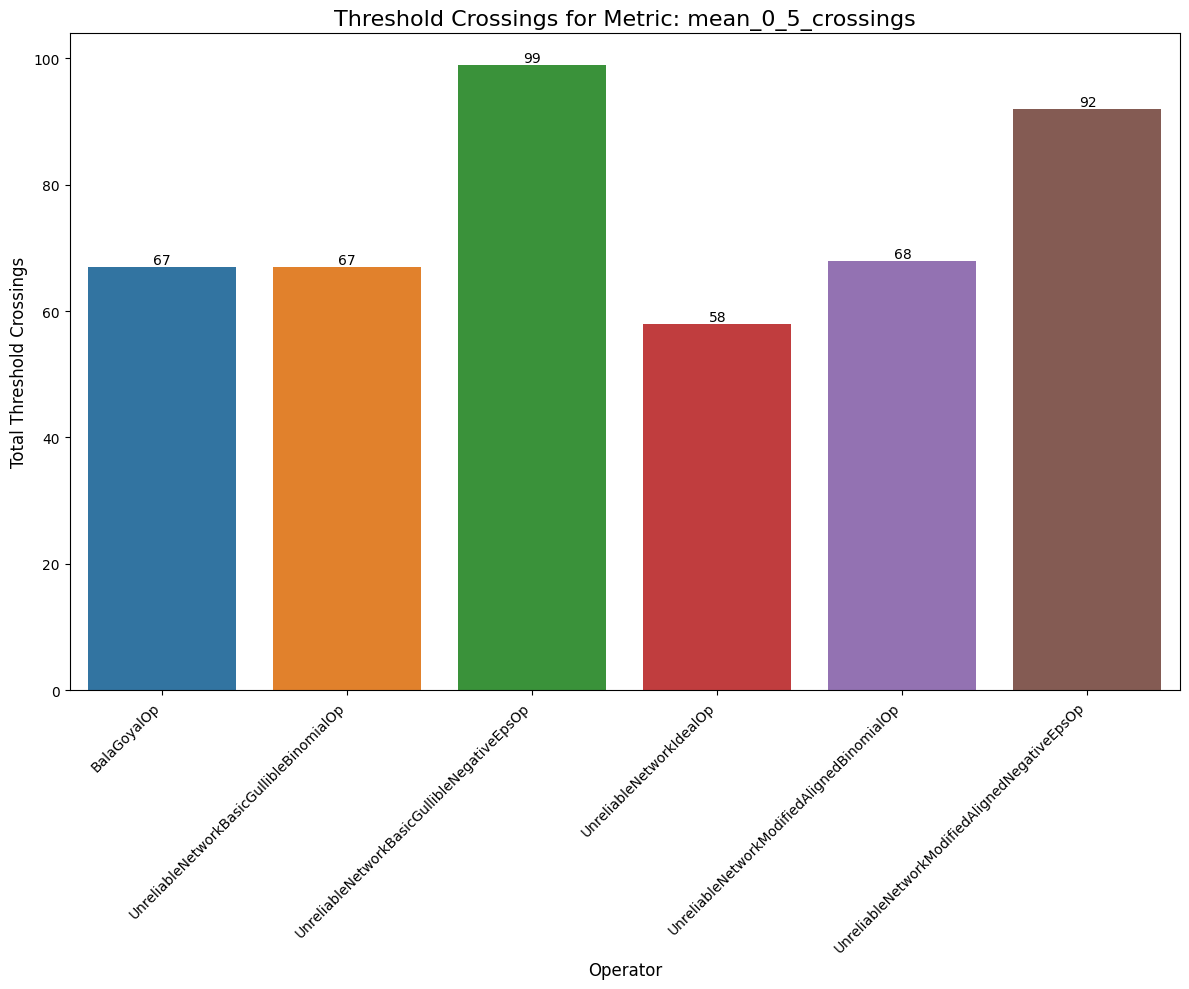

In [32]:
# Filter for a specific metric (e.g., mean_0_5_crossings)
metric_name = "mean_0_5_crossings"
filtered_metric = op_aggregated[[metric_name]].reset_index()

# Plot the comparison across operators
plt.figure(figsize=(12, 10))  # Increased figure size to provide more space
sns.barplot(data=filtered_metric, x="op", y=metric_name, palette="tab10")

# Add count on top of each bar
for p in plt.gca().patches:
    plt.text(
        p.get_x() + p.get_width() / 2,  # X position (center of the bar)
        p.get_height(),  # Y position (height of the bar)
        f'{int(p.get_height())}',  # Display the height as an integer
        ha='center',  # Horizontal alignment
        va='bottom',  # Vertical alignment (on top of the bar)
        fontsize=10,  # Font size of the text
        color='black'  # Text color
    )

# Title and labels
plt.title(f"Threshold Crossings for Metric: {metric_name}", fontsize=16)
plt.xlabel("Operator", fontsize=12)
plt.ylabel("Total Threshold Crossings", fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')  # Rotate the x-axis labels by 45 degrees

# Adjust layout to prevent overlap
plt.tight_layout()

# save the plot
plt.savefig("images/threshold for mean_0_5_crossings.png", format="png", dpi=300, bbox_inches="tight")
plt.savefig("images/threshold for mean_0_5_crossings.svg", format="svg", bbox_inches="tight")

# Show plot
plt.show()
